In [1]:
import zipfile
import os
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tensorflow.keras import layers, regularizers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import numpy as np


2025-07-02 12:38:07.045553: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751459887.260678      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751459887.318631      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
train_dir = "/kaggle/input/teeth-cellula/Teeth_Dataset/Training"
val_dir   = "/kaggle/input/teeth-cellula/Teeth_Dataset/Validation"
test_dir  = "/kaggle/input/teeth-cellula/Teeth_Dataset/Testing"

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


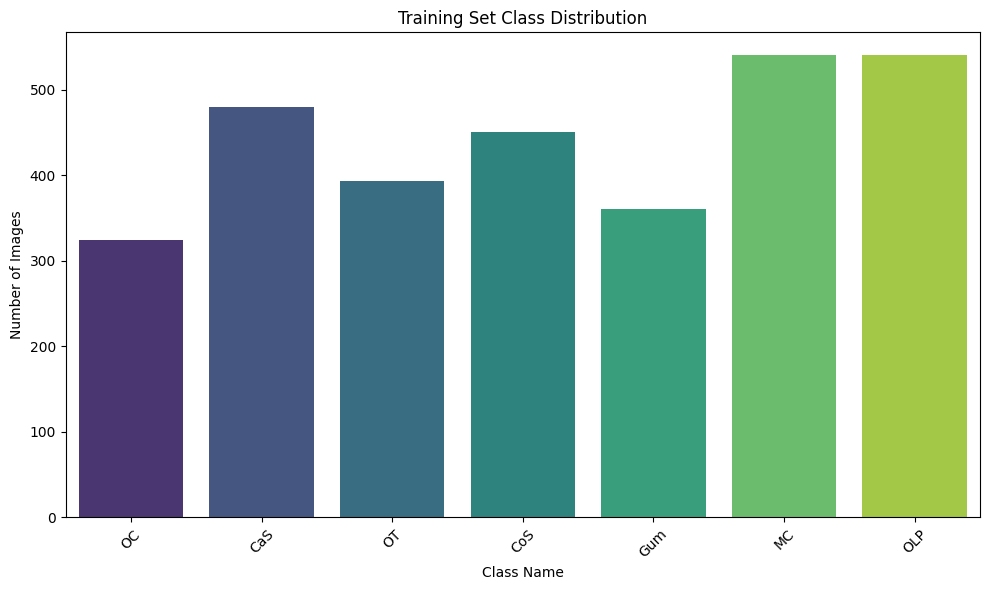

In [5]:
classes = os.listdir(train_dir)
class_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in classes}
class_names = list(class_counts.keys())
class_values = list(class_counts.values())
plt.figure(figsize=(10,6))
sns.barplot(x=class_names, y=class_values, palette='viridis')
plt.title("Training Set Class Distribution")
plt.ylabel("Number of Images")
plt.xlabel("Class Name")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

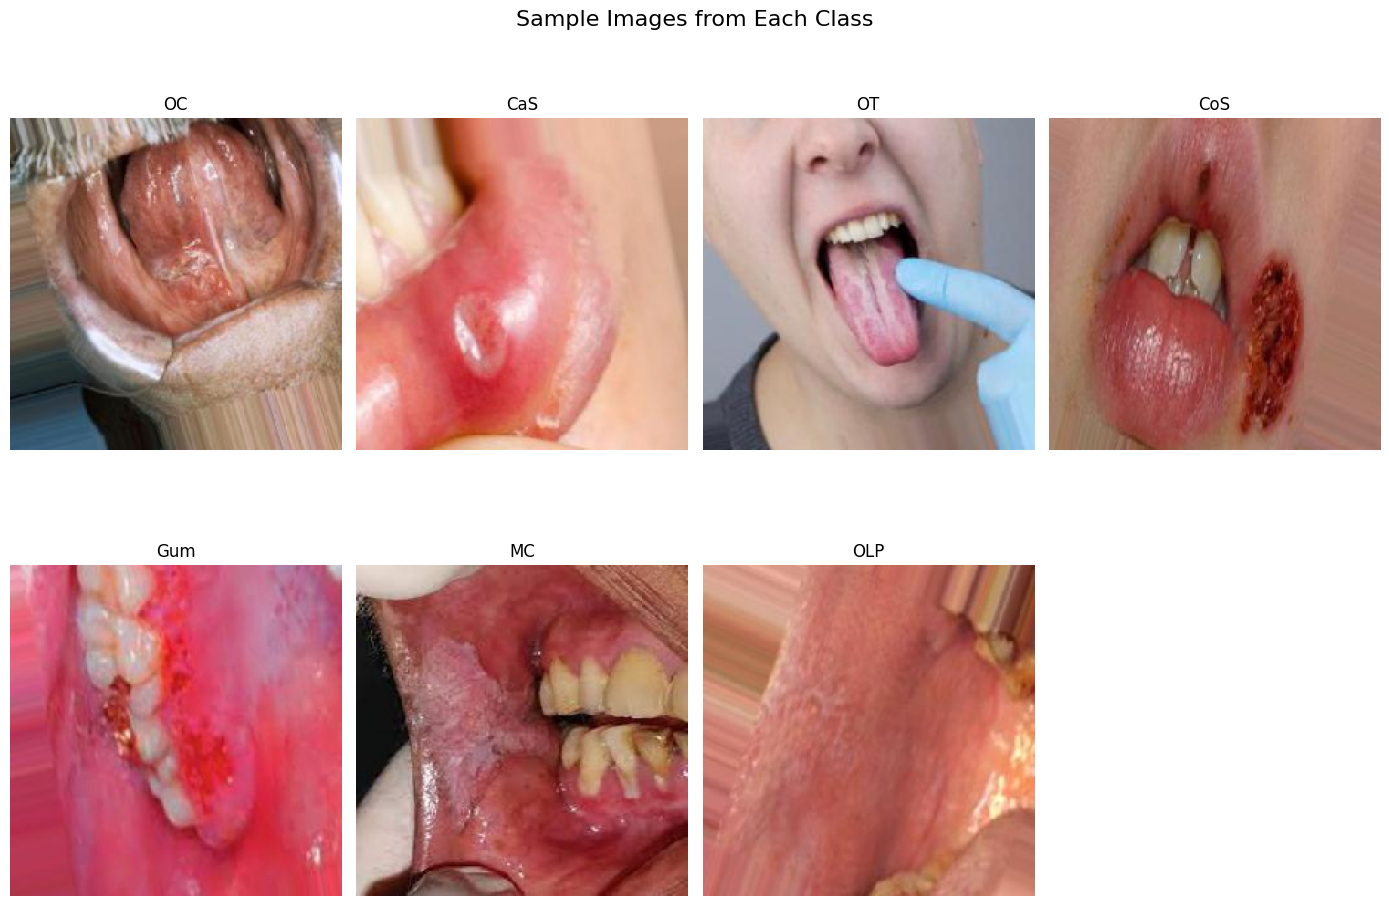

In [6]:
plt.figure(figsize=(14, 10))
for idx, class_name in enumerate(class_names[:7]):
    class_folder = os.path.join(train_dir, class_name)
    image_path = os.path.join(class_folder, random.choice(os.listdir(class_folder)))
    img = load_img(image_path, target_size=(224, 224))

    plt.subplot(2, 4, idx + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')

plt.suptitle("Sample Images from Each Class", fontsize=16)
plt.tight_layout()
plt.show()

In [7]:
train_datagen= ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.1,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

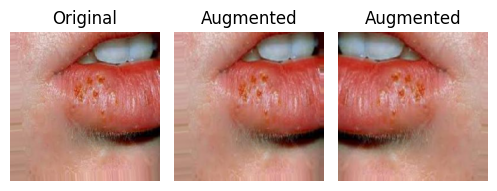

In [9]:
sample_class = class_names[3]
sample_image_path = os.path.join(train_dir, sample_class, os.listdir(os.path.join(train_dir, sample_class))[0])

# Load image and convert it to array
img = load_img(sample_image_path, target_size=(224, 224))
x = img_to_array(img)
x = x.reshape((1,) + x.shape)  # Reshape to match input shape expected by flow()

# Plot original image
plt.figure(figsize=(10, 5))
plt.subplot(1, 6, 1)
plt.imshow(img)
plt.title("Original")
plt.axis('off')

# Generate and plot 5 augmented images
i = 2
for batch in train_datagen.flow(x, batch_size=1):
    plt.subplot(1, 6, i)
    aug_img = array_to_img(batch[0])
    plt.imshow(aug_img)
    plt.title("Augmented")
    plt.axis('off')
    i += 1
    if i > 3:
        break

plt.tight_layout()
plt.show()

In [10]:
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(224, 224), batch_size=32, class_mode='categorical')

Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.


In [11]:
model= tf.keras.Sequential([
    layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.0001), input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(7, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy' ,metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1751460266.390515      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751460266.391179      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [12]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 256)       │           7,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 256)       │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 256)       │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 54, 54, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 26, 26, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 10, 10, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 3, 3, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 1, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,158,279 (4.42 MB)

 Trainable params: 1,156,743 (4.41 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [13]:
early_stop= EarlyStopping(monitor='val_loss', patience=13, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5',monitor='val_accuracy',save_best_only=True,mode='max')

In [14]:
history = model.fit(
    train_generator,
    epochs=70,
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/70


I0000 00:00:1751460326.546512     128 service.cc:148] XLA service 0x7add00118710 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751460326.547650     128 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751460326.547673     128 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751460327.162447     128 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-07-02 12:45:31.292634: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k11=0} for conv (f32[32,256,109,109]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,256,111,111]{3,2,1,0}, f32[256,256,3,3]{3,2,1,0}, f32[256]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":f

31/97 ━━━━━━━━━━━━━━━━━━━━ 28s 435ms/step - accuracy: 0.1628 - loss: 2.2860

E0000 00:00:1751460375.135931     130 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1751460375.451682     130 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


97/97 ━━━━━━━━━━━━━━━━━━━━ 109s 782ms/step - accuracy: 0.1911 - loss: 2.0910 - val_accuracy: 0.1741 - val_loss: 1.9295
Epoch 2/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 42s 430ms/step - accuracy: 0.2798 - loss: 1.7971 - val_accuracy: 0.2150 - val_loss: 1.8867
Epoch 3/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 41s 419ms/step - accuracy: 0.3314 - loss: 1.6964 - val_accuracy: 0.2743 - val_loss: 1.8762
Epoch 4/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 42s 427ms/step - accuracy: 0.3920 - loss: 1.5996 - val_accuracy: 0.2140 - val_loss: 1.9345
Epoch 5/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 41s 418ms/step - accuracy: 0.4337 - loss: 1.5066 - val_accuracy: 0.3006 - val_loss: 1.7510
Epoch 6/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 41s 419ms/step - accuracy: 0.4904 - loss: 1.3694 - val_accuracy: 0.4086 - val_loss: 1.5831
Epoch 7/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 43s 437ms/step - accuracy: 0.5164 - loss: 1.2718 - val_accuracy: 0.3327 - val_loss: 1.9687
Epoch 8/70
97/97 ━━━━━━━━━━━━━━━━━━━━ 41s 421ms/step - accuracy: 0.5211 - loss: 1.2500 - val_accuracy: 0.39

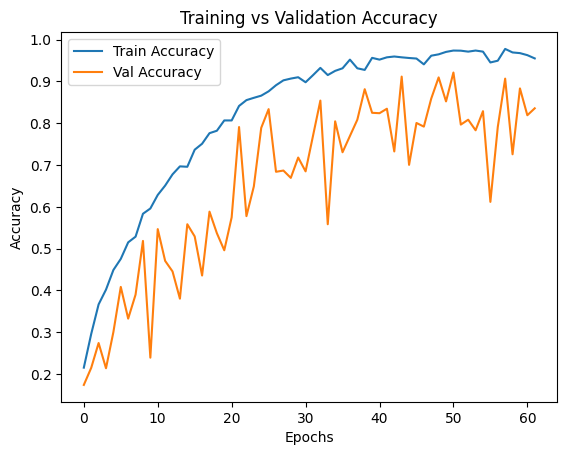

In [15]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

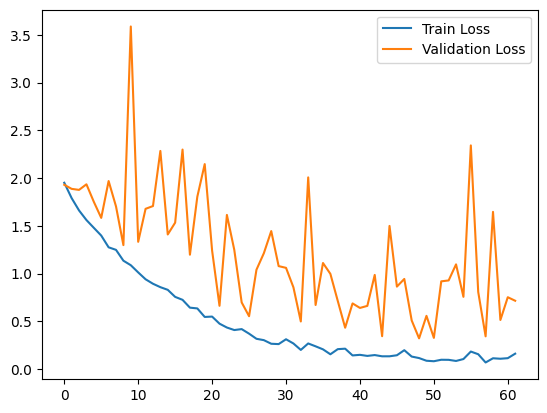

In [16]:
plt.plot(history.history['loss'], label = 'Train Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.legend()
plt.show()

In [17]:
loss, acc = model.evaluate(test_generator)
print(f"Test accuracy: {acc:.2f}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 165ms/step - accuracy: 0.9161 - loss: 0.3355
Test accuracy: 0.90


In [18]:
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step


In [19]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

         CaS       0.13      0.13      0.13       160
         CoS       0.12      0.13      0.13       149
         Gum       0.07      0.07      0.07       120
          MC       0.18      0.18      0.18       180
          OC       0.06      0.06      0.06       108
         OLP       0.18      0.18      0.18       180
          OT       0.14      0.16      0.15       131

    accuracy                           0.14      1028
   macro avg       0.13      0.13      0.13      1028
weighted avg       0.13      0.14      0.13      1028



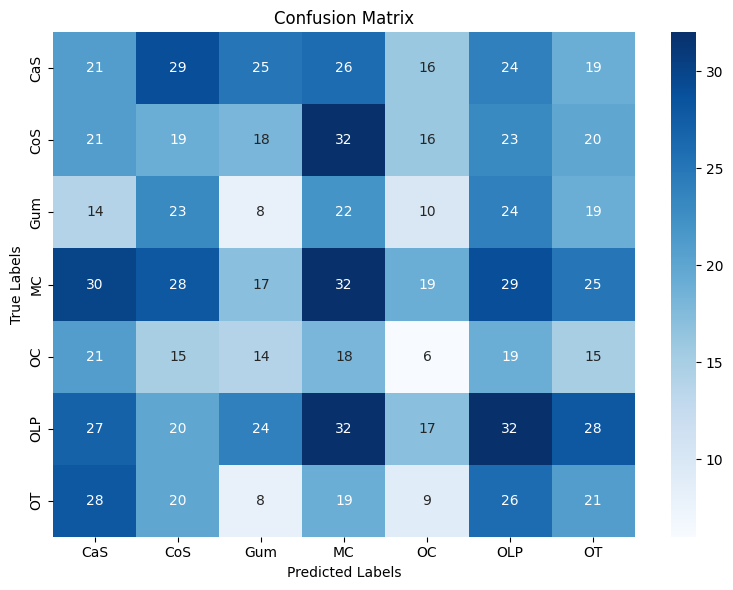

In [20]:
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


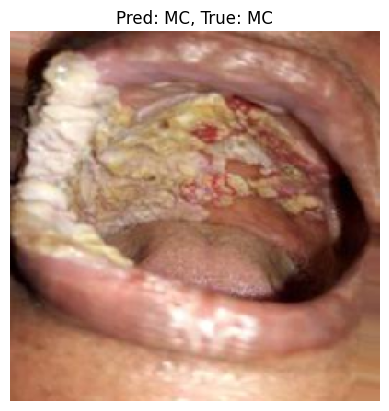

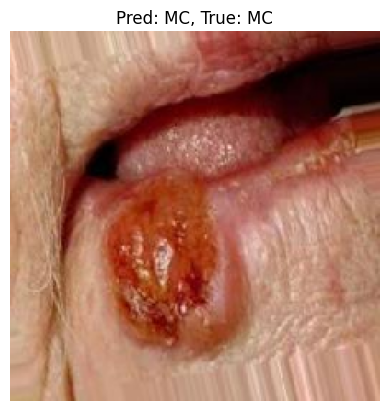

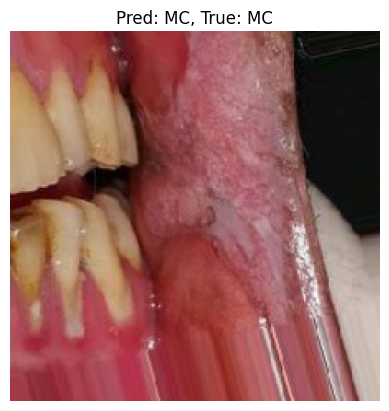

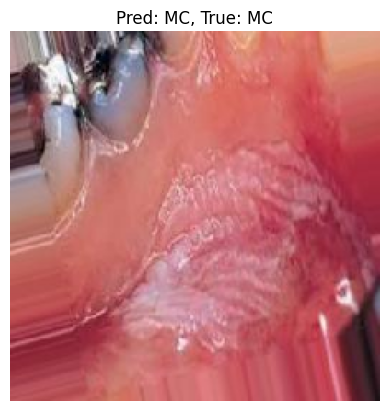

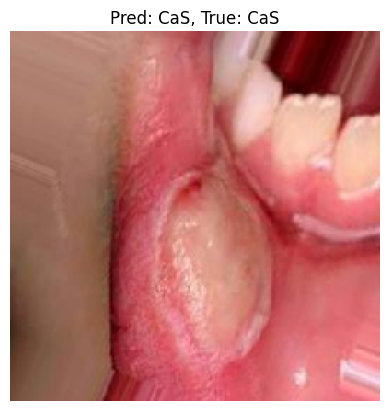

In [24]:
# Get class label mappings
class_indices = train_generator.class_indices
inv_class_indices = {v: k for k, v in class_indices.items()}

# Get a batch of test data
test_images, test_labels = next(test_generator)

# Predict
preds = model.predict(test_images)

for i in range(5):  # Show first 5 predictions
    plt.imshow(test_images[i])
    pred_class = inv_class_indices[np.argmax(preds[i])]
    true_class = inv_class_indices[np.argmax(test_labels[i])]
    plt.title(f"Pred: {pred_class}, True: {true_class}")
    plt.axis('off')
    plt.show()
